In [2]:
%run utils_rf

In [3]:
#read training data
file = "C:/Users/USERID/Documents/GitHub/Employment2030/Employment2030/tables/noc_answers.csv"
x, x_agg, y, y_agg, x_noclvl, y_noclvl = data_proccess(file)

Below we use mutual information to rank features (regression and classification respectively) then pick the k best and run the models. We do this for each K and compare MAE

In [ ]:
r_mi_scores, c_mi_scores = scores_by_k(x, x_agg, y, y_agg)

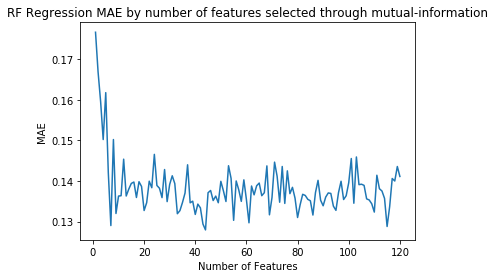

In [368]:
plt.plot(r_mi_scores)
plt.xlabel('Number of Features')
plt.ylabel('MAE')
plt.title('RF Regression MAE by Number of Features Selected Through Mutual-Information')
plt.show()

In [82]:
print(r_mi_scores.idxmin())
print(r_mi_scores.min())

44
0.12794285678678982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


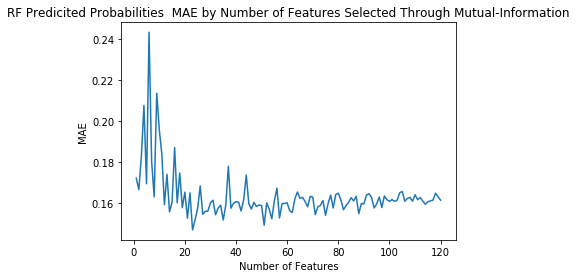

In [369]:
plt.plot(c_mi_scores)
plt.xlabel('Number of Features')
plt.ylabel('MAE')
plt.title('RF Predicited Probabilities  MAE by Number of Features Selected Through Mutual-Information')
plt.show()

In [84]:
print(c_mi_scores.idxmin())
print(c_mi_scores.min())

23
0.1468320023880416


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


CHANGE HOW THIS WORKS

In [62]:
increase_pred_cut = run_models(x, x_agg, y, y_agg,True,True,44,23)

In [63]:
increase_cut_acc = abs(increase_pred_cut.subtract(y_agg['increase'],axis=0))
inc_reg_cut_confusion = confusion_matrix(increase_pred['regression'],y_agg['increase'],True)
inc_prob_cut_confusion = confusion_matrix(increase_pred['pred_prob'],y_agg['increase'],True)
increase_cut_acc.mean() 

regression       0.139786
pred_prob        0.164799
tree_portions    0.208402
dtype: float64

In [64]:
inc_reg_cut_confusion

,pred_increase,pred_decrease
true_increase,13,18
true_decrease,1,88


In [65]:
inc_prob_cut_confusion

,pred_increase,pred_decrease
true_increase,18,13
true_decrease,16,73


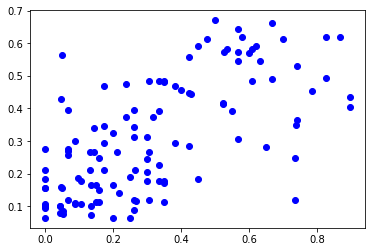

In [66]:
plt.plot(y_agg['increase'],increase_pred_cut['regression'],'bo')

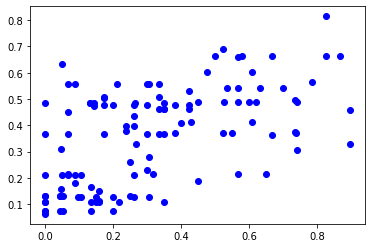

In [67]:
plt.plot(y_agg['increase'],increase_pred_cut['pred_prob'],'bo')

OK next we do an the same thing but sorting on rf feature importance
-TODO fold this code into the broader framework

In [6]:
features_pred_prob_kfold = k_fold_feature_importance(x,y['increase'],'cat')
features_pred_prob_kfold = pd.Series(features_pred_prob_kfold,index=x.columns)
features_pred_prob_kfold = features_pred_prob_kfold.sort_values(ascending=False)

In [7]:
features_reg_kfold = k_fold_feature_importance(x_agg,y_agg['increase'],'reg')
features_reg_kfold = pd.Series(features_reg_kfold,index=x.columns)
features_reg_kfold = features_reg_kfold.sort_values(ascending=False)

In [8]:
reg_scores = np.zeros((120,120))
class_scores = np.zeros((120,120))

r_scores = pd.DataFrame()
c_scores = pd.DataFrame()

for i in range(5):
    for k in range(1,121):
        reg_scores[k-1] = run_k_fold(x_agg[features_reg_kfold.index[0:k]],
                            y_agg['increase'],
                            init_params('reg'),
                            x_agg.index,
                            True,'reg').iloc[:,0].values
        class_scores[k-1] = run_k_fold(x[features_pred_prob_kfold.index[0:k]],
                            y['increase'],
                            init_params('cat'),
                            x.index,
                            True,'pred_probs').iloc[:,0].values

    r_scores[i] = abs(pd.DataFrame(reg_scores,index=range(1,121),columns=x_agg.index).T.subtract(y_agg['increase'],axis=0)).mean(axis=0)
    c_scores[i] = abs(pd.DataFrame(class_scores,index=range(1,121),columns=x_agg.index).T.subtract(y_agg['increase'],axis=0)).mean()

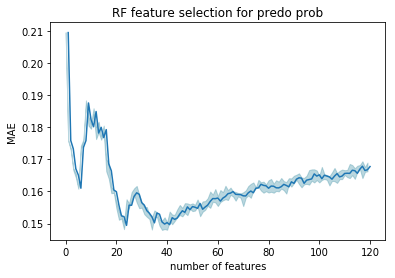

In [9]:
_, ax = plt.subplots()

# Plot the data, set the linewidth, color and transparency of the
# line, provide a label for the legend
ax.plot(c_scores.mean(axis=1))
# Shade the confidence interval
ax.fill_between(range(0,120), c_scores.max(axis=1), c_scores.min(axis=1), color = '#539caf', alpha = 0.4)
# Label the axes and provide a title
ax.set_title('RF feature selection for predo prob')
ax.set_xlabel('number of features')
ax.set_ylabel('MAE')

# Display legend
plt.show()

In [14]:
print(c_scores.mean(axis=1).idxmin())
print(c_scores.mean(axis=1).min())

24
0.14942795828692995


In [22]:
rfs_prob_features = features_pred_prob_kfold.index[0:24]

In [26]:
inc_prob_rfs = run_k_fold(x.loc[:,rfs_prob_features],y['increase'],init_params('cat'),x.index,True,'pred_probs')

In [27]:
abs(inc_prob_rfs.subtract(y_agg['increase'],axis=0)).mean()

0    0.149142
dtype: float64

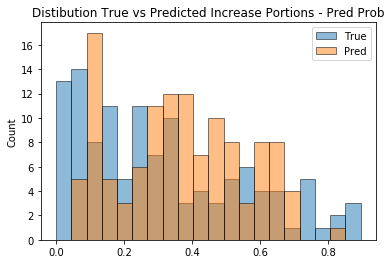

In [29]:
bins=np.histogram(np.hstack((y_agg['increase'],inc_prob_rfs[0])), bins=20)[1]

fig, ax = plt.subplots()
plt.hist(y_agg['increase'],bins, alpha = 0.5, edgecolor = 'black',label='True')
plt.hist(inc_prob_rfs[0],bins, alpha = 0.5, edgecolor = 'black',label='Pred')
plt.legend(loc='upper right')
ax.set_ylabel('Count')
ax.set_title('Distibution True vs Predicted Increase Portions - Pred Prob')

plt.show()

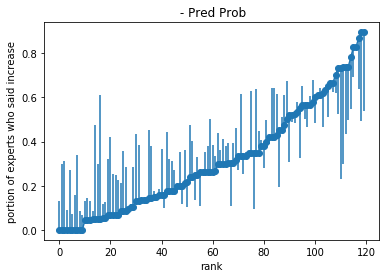

In [30]:
inc_prob_rfs_acc = np.asarray(y_agg['increase']-inc_prob_rfs[0])
error_prob_sfs = pd.DataFrame({'true':y_agg['increase'],'error':inc_prob_rfs_acc}).sort_values('true')
fig, ax = plt.subplots()

ax.errorbar(range(0,120),error_prob_sfs['true'],
            yerr=np.row_stack((error_prob_sfs['error'],np.zeros(120))),fmt='-o')

ax.set_xlabel('rank')
ax.set_ylabel('portion of experts who said increase')
ax.set_title(' - Pred Prob')
plt.savefig('prob_error.png',pad_inches=0.25)

In [31]:
inc_prob_confusion = confusion_matrix(inc_prob_rfs[0],y_agg['increase'],True)
inc_prob_confusion

,pred_increase,pred_decrease
true_increase,19,12
true_decrease,10,79


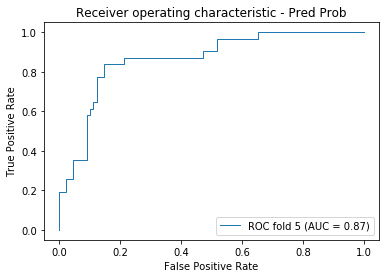

In [32]:
true_labels = y_agg['increase'].where(y_agg['increase']>=0.5,0).where(y_agg['increase']<0.5,1)
fpr, tpr, thresholds = roc_curve(true_labels,inc_prob_rfs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1,label='ROC fold %d (AUC = %0.2f)' % (5, roc_auc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Pred Prob')
plt.legend(loc="lower right")
plt.savefig('roc_prob.png')
plt.show()

In [33]:
true_labels = y_agg['increase'].where(y_agg['increase']>=0.5,0).where(y_agg['increase']<0.5,1)
log_loss(true_labels,inc_prob_rfs)

0.4610664258469177

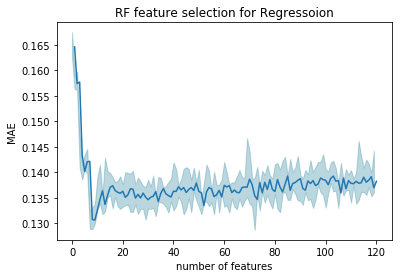

In [10]:
_, ax = plt.subplots()

# Plot the data, set the linewidth, color and transparency of the
# line, provide a label for the legend
ax.plot(r_scores.mean(axis=1))
# Shade the confidence interval
ax.fill_between(range(0,120), r_scores.max(axis=1), r_scores.min(axis=1), color = '#539caf', alpha = 0.4)
# Label the axes and provide a title
ax.set_title('RF feature selection for Regressoion')
ax.set_xlabel('number of features')
ax.set_ylabel('MAE')

# Display legend
plt.show()